In [1]:


import vsketch
import numpy as np
from shapely.geometry import (Point, MultiPoint, MultiPolygon)

from fn.fn import new_savepath

import itertools
from matplotlib import pyplot as plt

from geodude.utils import Paper, merge_LineStrings, flatten_geoms
from geodude.ops import make_like
from geodude.intersection import (
    pairwise_partition_polygons, 
    find_parent_polygons,
    merge_disjoint_polys,
    assign_random_order_to_adjacent_clusters,
    assign_psuedoperiodic_order_to_adjacent_clusters,
    chunked_pairwise_partition_polygons
    )

%load_ext autoreload
%autoreload 2

# make page
paper_size = '11x14 inches'
border:float=30
paper = Paper(paper_size)

drawbox = paper.get_drawbox(border)

# simple example

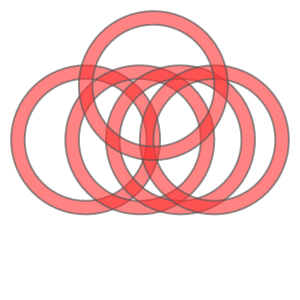

In [142]:
c0 = Point(0,0).buffer(100).boundary.buffer(10)
c1 = Point(80,0).buffer(100).boundary.buffer(10)
c2 = Point(140,0).buffer(100).boundary.buffer(10)
c3 = Point(190,0).buffer(100).boundary.buffer(10)
c4 = Point(100,80).buffer(100).boundary.buffer(10)

mp = MultiPolygon([
    c0, 
    c1, 
    c2, 
    c3, 
    c4,
    ])
mp

In [208]:
gdf = flatten_geoms(mp.geoms)
gdf

,geometry
0,"POLYGON ((109.988 0.491, 109.988 -0.491, 109.5..."
1,"POLYGON ((189.988 0.491, 189.988 -0.491, 189.5..."
2,"POLYGON ((249.988 0.491, 249.988 -0.491, 249.5..."
3,"POLYGON ((299.988 0.491, 299.988 -0.491, 299.5..."
4,"POLYGON ((209.988 80.491, 209.988 79.509, 209...."


12
4
24
19
13
7
16
13
21
11
16
14
10
7
5
9
4
4
4
2
0


Text(0, 0.5, 'n_intersections')

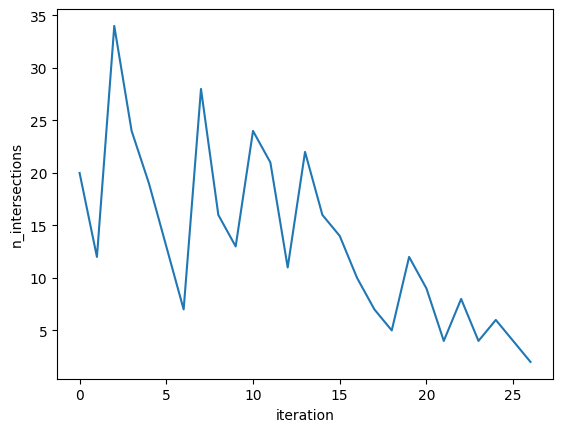

In [209]:
disjoint, n_intersections_log = pairwise_partition_polygons(
    gdf, 
    verbose=True,
    min_area=1e-5
    )
plt.plot(n_intersections_log)
plt.xlabel('iteration')
plt.ylabel('n_intersections')

In [168]:
disjoint

,geometry
0,"POLYGON ((69.845 -84.711, 62.574 -78.120, 61.8..."
1,"POLYGON ((61.880 77.426, 62.574 78.120, 69.845..."
2,"POLYGON ((169.988 -0.000, 169.555 8.820, 168.2..."
3,"POLYGON ((189.506 -10.292, 189.410 -11.269, 18..."
4,"POLYGON ((166.113 26.122, 163.138 34.437, 159...."
...,...
58,"POLYGON ((30.012 -0.491, 30.012 0.491, 30.494 ..."
59,"POLYGON ((54.667 -69.396, 48.821 -61.514, 48.2..."
60,"POLYGON ((32.030 20.976, 30.590 11.269, 30.494..."
61,"POLYGON ((32.221 21.939, 34.606 31.458, 34.891..."


In [211]:
disjoint = find_parent_polygons(disjoint=disjoint, original=gdf)
disjoint

,geometry,adjacent_polys,intersecting_original_polygons,order,n_parents
61,"POLYGON ((140.698 91.724, 141.514 91.179, 143....","{44, 47, 48, 49, 20, 62}","{1, 2, 3}",(),3
45,"POLYGON ((99.509 -29.988, 89.708 -29.506, 88.7...","{58, 9, 10, 46, 22, 24, 56, 59}","{0, 3, 4}",(),3
43,"POLYGON ((188.259 97.556, 187.927 98.882, 191....","{44, 51, 53, 54, 30, 31}","{2, 3, 4}",(),3
1,"POLYGON ((129.302 -91.724, 128.486 -91.179, 12...","{2, 19, 21, 25, 27}","{1, 2, 3}",(),3
0,"POLYGON ((-9.506 90.292, -9.410 91.269, -7.970...","{32, 42, 13, 7}","{0, 4}",(),2
...,...,...,...,...,...
35,"POLYGON ((70.000 84.838, 69.845 84.711, 62.574...","{34, 36, 37, 6, 8, 14}",{0},"(0,)",1
36,"POLYGON ((78.120 77.426, 77.426 78.120, 70.155...","{34, 35, 8, 48, 60, 62}",{2},"(2,)",1
37,"POLYGON ((57.088 69.562, 63.631 63.631, 69.562...","{34, 35, 5, 12, 23, 60}",{2},"(2,)",1
10,"POLYGON ((105.828 -29.726, 105.560 -30.798, 10...","{4, 9, 45, 46, 29}",{0},"(0,)",1


In [170]:
# changing how this works would be interesting
disjoint = assign_psuedoperiodic_order_to_adjacent_clusters(disjoint)
disjoint

,geometry,adjacent_polys,intersecting_original_polygons,order,n_parents,parent
19,"POLYGON ((101.741 -17.556, 103.887 -26.122, 10...","{50, 51, 20, 21, 52, 25, 26, 28}","{0, 3, 4}","(0, 3, 4)",3,0
17,"POLYGON ((141.514 91.179, 143.341 89.824, 140....","{32, 33, 37, 44, 18}","{1, 2, 3}","(1, 2, 3)",3,1
43,"POLYGON ((192.281 96.769, 200.698 91.724, 201....","{40, 41, 44, 53, 54, 57}","{2, 3, 4}","(4, 2, 3)",3,4
38,"POLYGON ((128.486 -91.179, 125.075 -88.649, 13...","{39, 13, 16, 29, 30, 31}","{1, 2, 3}","(3, 1, 2)",3,3
21,"POLYGON ((105.560 -30.798, 105.394 -31.458, 10...","{10, 11, 50, 19, 52, 25, 28}","{0, 3}","(0, 3)",2,0
...,...,...,...,...,...,...
30,"POLYGON ((161.939 -107.779, 160.976 -107.970, ...","{38, 42, 13, 14, 29}",{2},"(2,)",1,2
32,"POLYGON ((143.341 89.824, 148.820 89.555, 157....","{4, 44, 17, 18, 57}",{3},"(3,)",1,3
34,"POLYGON ((113.878 86.113, 122.444 88.259, 125....","{9, 35, 33}",{1},"(1,)",1,1
35,"POLYGON ((105.563 83.138, 97.580 79.362, 90.00...","{1, 34, 33, 36, 8, 12}",{2},"(2,)",1,2


In [172]:
# merge based on 'parent' column
ngdf = merge_disjoint_polys(disjoint)
ngdf


,geometry
0,"POLYGON ((51.415 -97.232, 42.544 -101.428, 41...."
1,"POLYGON ((83.138 34.437, 79.362 42.420, 74.822..."
2,"POLYGON ((61.880 77.426, 55.691 70.598, 49.995..."
3,"POLYGON ((60.698 -91.724, 61.514 -91.179, 64.9..."
4,"POLYGON ((-9.988 0.000, -9.555 -8.820, -8.259 ..."
5,"POLYGON ((22.912 69.562, 16.369 63.631, 12.510..."
6,"POLYGON ((185.394 -31.458, 185.109 -32.397, 18..."
7,"POLYGON ((55.691 -70.598, 55.289 -70.155, 54.6..."
8,"POLYGON ((150.292 -109.506, 140.491 -109.988, ..."
9,"POLYGON ((225.333 69.396, 231.179 61.514, 231...."


In [173]:
# clean up with closing + opening
buffer_value = 0.1
ngdf.geometry = ngdf.buffer(buffer_value).buffer(-buffer_value)
ngdf.geometry = ngdf.buffer(-buffer_value).buffer(buffer_value)
ngdf = ngdf.explode(index_parts=False)

ngdf['area'] = ngdf.area
idx = ngdf.is_valid & (ngdf.area > 1e-6) & ~ngdf.is_empty & (ngdf.geom_type == 'Polygon')
ngdf = ngdf[idx]

lss = [p.boundary for p in ngdf.geometry if p.boundary is not None]
mls = merge_LineStrings(lss)
mls = make_like(mls, drawbox)

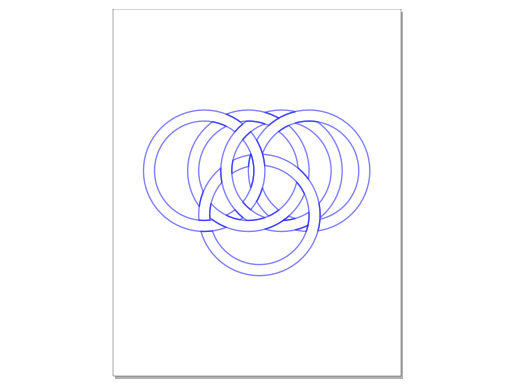

In [175]:
sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)

sk.geometry(mls)
sk.display()


# complex

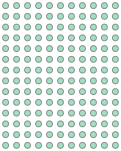

In [17]:
n_xs = 11
n_ys = 14
n_pts = n_xs * n_ys
xs = np.linspace(0, 110, n_xs)
ys = np.linspace(0, 140, n_ys)
pts = [Point(x, y) for x, y in itertools.product(xs, ys)]
radii = [np.interp(pt.y, [0, 140], [1, 15]) for pt in pts]
thicknesses = [np.interp(pt.y, [0, 140], [0.5, 1]) for pt in pts]

MultiPoint(pts)

In [18]:
circles = [p.buffer(r).boundary.buffer(thickness) for p,r, thickness in zip(pts, radii, thicknesses)]

In [ ]:
gdf = flatten_geoms(circles)
disjoint = chunked_pairwise_partition_polygons(
    gdf, 
    chunk_size=10,
    min_area=1e-3,
    )


In [21]:

disjoint = find_parent_polygons(disjoint=disjoint, original=gdf)


In [29]:

disjoint = assign_random_order_to_adjacent_clusters(disjoint)
ngdf = merge_disjoint_polys(disjoint)

# clean up with closing + opening
buffer_value = 0.1
ngdf.geometry = ngdf.buffer(buffer_value).buffer(-buffer_value)
ngdf.geometry = ngdf.buffer(-buffer_value).buffer(buffer_value)
ngdf = ngdf.explode(index_parts=False)


In [31]:

ngdf['area'] = ngdf.area
idx = (ngdf.area > 1e-6) & ~ngdf.is_empty & (ngdf.geom_type == 'Polygon')
idx = idx & ngdf.is_valid
ngdf = ngdf[idx]

lss = [p.boundary for p in ngdf.geometry if p.boundary is not None]
mls = merge_LineStrings(lss)
mls = make_like(mls, drawbox)


/Users/alexandernaka/code/art/brr/libraries/geodude/geodude/utils.py:70: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if getattr(mls, "type") == "MultiLineString":
/Users/alexandernaka/code/art/brr/libraries/geodude/geodude/utils.py:72: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif getattr(mls, "type") == "LineString":


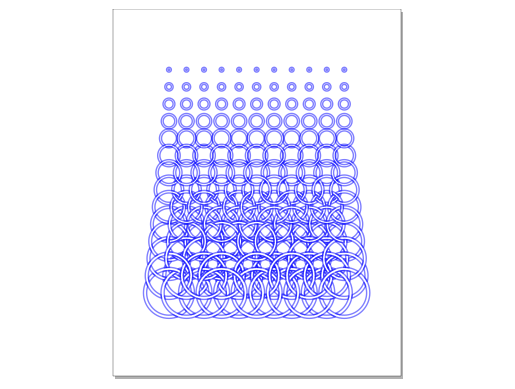

In [32]:
sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)

sk.geometry(mls)
sk.display()


In [33]:
fp = new_savepath(postfix='ringlock')

In [34]:
sk.save(fp)